#### Author: Dasha Asienga


In this notebook, we will compile the results from our experiments into a CSV file. This will make it easier for us to plot these results in the final step. 

As always, let's begin by importing the necessary packages. 

`csv` implements classes to read and write tabular data in CSV format.
`glob` finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. This will be usefil for referencing our file paths and names. 
`re` provides regular expression matching operations similar to those found in Perl.

We've seen `numpy` and `matplotlib` before, which help with numerical operations and plotting respectively.

In [1]:
import numpy as np
import csv 
import glob 
import re 
import matplotlib.pyplot as plt 

Let's now define the path where we saved our experiment results and where we will be synthesizing the results in a csv format.

In [2]:
bin_path = 'experiment_results_dasha/bin/'
csv_path = 'experiment_results_dasha/csv/'

The function below gets the existing experiment numbers by parsing through the files where our experiment results are saved. For example, the `results1.npz` file stores the results from experiment 1. The expriment number, thus, is 1.

In [3]:
def get_existing_experiment_numbers():
    result_files       = glob.glob(bin_path + 'results*.npz')
    experiment_numbers = [re.search('.*results([0-9]*).*', fn, re.IGNORECASE) for fn in result_files]
    experiment_numbers = [int(i.group(1)) for i in experiment_numbers]
    experiment_numbers.sort()
    return experiment_numbers

Next, let's re-generate the file name. We will use these to load the experiment results. Essentially, `%d` is replaced by the value of `n` for all of our n experiments.

In [5]:
def genFilename(n):
    return bin_path + 'results%d.npz' % n

The following function will add more results to our folder. We begin by loading the `npz` files storing the experiment results and extracting all the relevant information that we had stored in a compressed format into arrays.

Recall that: 
- `ms`: data set size
- `seldonian_solutions_found`: stores whether a solution was found (1=True,0=False)
- `seldonian_fs`: stores the primary objective values (fHat) if a solution was found
- `seldonian_failures_g1`: stores whether Seldonian solution was unsafe, (1=True,0=False), for the 1st constraint, g_1
- `seldonian_failures_g2`: stores whether Seldonian solution was unsafe, (1=True,0=False), for the 2nd constraint, g_2
- `LS_solutions_found`: stores whether a solution was found. These will all be true (=1)
- `LS_fs`: stores the primary objective values (f) 
- `LS_failures_g1`: stores whether LS solution was unsafe, (1=True,0=False), for the 1st constraint, g_1
- `LS_failures_g2`: stores whether LS solution was unsafe, (1=True,0=False), for the 2nd constraint, g_2

`np.vstack` stacks arrays in sequence vertically (rowwise).

In [6]:
def addMoreResults(newFileId, ms, seldonian_solutions_found, seldonian_fs, seldonian_failures_g1, seldonian_failures_g2,
    LS_solutions_found, LS_fs, LS_failures_g1, LS_failures_g2):

    newFile = np.load(genFilename(newFileId))
    new_ms                        = newFile['ms']
    new_seldonian_solutions_found = newFile['seldonian_solutions_found']
    new_seldonian_fs              = newFile['seldonian_fs']
    new_seldonian_failures_g1     = newFile['seldonian_failures_g1']
    new_seldonian_failures_g2     = newFile['seldonian_failures_g2']
    new_LS_solutions_found        = newFile['LS_solutions_found']
    new_LS_fs                     = newFile['LS_fs']
    new_LS_failures_g1            = newFile['LS_failures_g1']
    new_LS_failures_g2            = newFile['LS_failures_g2']

    if type(ms)==type(None):
        return [new_ms, new_seldonian_solutions_found, new_seldonian_fs, new_seldonian_failures_g1, new_seldonian_failures_g2,
                new_LS_solutions_found, new_LS_fs, new_LS_failures_g1, new_LS_failures_g2]
    else:
        #ms                         = np.vstack([ms,                        new_ms])
        seldonian_solutions_found  = np.vstack([seldonian_solutions_found, new_seldonian_solutions_found])
        seldonian_fs               = np.vstack([seldonian_fs,              new_seldonian_fs])
        seldonian_failures_g1      = np.vstack([seldonian_failures_g1,     new_seldonian_failures_g1])
        seldonian_failures_g2      = np.vstack([seldonian_failures_g2,     new_seldonian_failures_g2])
        LS_solutions_found         = np.vstack([LS_solutions_found,        new_LS_solutions_found])
        LS_fs                      = np.vstack([LS_fs,                     new_LS_fs])
        LS_failures_g1             = np.vstack([LS_failures_g1,            new_LS_failures_g1])
        LS_failures_g2             = np.vstack([LS_failures_g2,            new_LS_failures_g2])

        return [ms, seldonian_solutions_found, seldonian_fs, seldonian_failures_g1, seldonian_failures_g2, 
                LS_solutions_found, LS_fs, LS_failures_g1, LS_failures_g2]



The function below returns the number of valid (non NaN) elements in the vector.

In [7]:
def stderror(v):
    non_nan = np.count_nonzero(~np.isnan(v))        
    return np.nanstd(v, ddof=1) / np.sqrt(non_nan)

Now, let's write a function that will save our results to a CSV file. 

The output CSV file will have columns corresponding to:
1. `m` -- the size of the data set
2. QSA mean value
3. QSA standard error bar size
4. LS mean value
5. LS standard error bar size 

There will be one column per value of `m` (amount of training data). 

In [8]:
def saveToCSV(ms, resultsQSA, resultsLS, filename):
    nCols = resultsQSA.shape[1]


    with open(filename, mode='w') as file:
        writer = csv.writer(file, delimiter=',')

        for col in range(nCols):

            cur_m          = ms[col]
            seldonian_data = resultsQSA[:,col]
            LS_data        = resultsLS[:,col]

            non_nan = np.count_nonzero(~np.isnan(seldonian_data))
            if non_nan > 0:
                seldonian_mean     = np.nanmean(seldonian_data)
                seldonian_stderror = stderror(seldonian_data)
            else:
                seldonian_mean     = 'NaN'
                seldonian_stderror = 'NaN'

            LS_mean     = np.mean(LS_data)
            LS_stderror = stderror(LS_data)

            writer.writerow([cur_m, seldonian_mean, seldonian_stderror, LS_mean, LS_stderror])

The following function gathers all the results and writes them to the respective CSV files, as described above.

In [9]:
def gather_results():
    ms                        = None
    seldonian_solutions_found = None
    seldonian_fs              = None
    seldonian_failures_g1     = None
    seldonian_failures_g2     = None
    LS_solutions_found        = None
    LS_fs                     = None
    LS_failures_g1            = None
    LS_failures_g2            = None

    experiment_numbers = get_existing_experiment_numbers()

    for file_idx in experiment_numbers:
        res = addMoreResults(file_idx, 
            ms, 
            seldonian_solutions_found, seldonian_fs, seldonian_failures_g1, seldonian_failures_g2, 
            LS_solutions_found, LS_fs, LS_failures_g1, LS_failures_g2)
        
        [ms, 
        seldonian_solutions_found, seldonian_fs, seldonian_failures_g1, seldonian_failures_g2, 
        LS_solutions_found, LS_fs, LS_failures_g1, LS_failures_g2] = res


    saveToCSV(ms,  -1*seldonian_fs,            -1*LS_fs,           csv_path+'fs.csv') # here, negative to return MSE rather than negative MSE
    saveToCSV(ms,  seldonian_solutions_found,  LS_solutions_found, csv_path+'solutions_found.csv')
    saveToCSV(ms,  seldonian_failures_g1,      LS_failures_g1,     csv_path+'failures_g1.csv')
    saveToCSV(ms,  seldonian_failures_g2,      LS_failures_g2,     csv_path+'failures_g2.csv')

In [10]:
csv_path = 'experiment_results_dasha/csv/'
img_path = 'images/'

Finally, we will load the synthesized results from the CSV files and plot them in order to visualize performance. This function achieves that.

We will print the images, but also save them in the `images/` folder.

In [11]:
def loadAndPlotResults(fileName, ylabel, output_file, is_yAxis_prob, legend_loc):
    file_ms, file_QSA, file_QSA_stderror, file_LS, file_LS_stderror = np.loadtxt(fileName, delimiter=',', unpack=True)

    fig = plt.figure()

    plt.xlim(min(file_ms), max(file_ms))
    plt.xlabel("Amount of data (m)", fontsize=16)
    plt.xscale('log')
    plt.xticks(fontsize=12)
    plt.ylabel(ylabel, fontsize=16)

    if is_yAxis_prob:
        plt.ylim(-0.1, 1.1)
    else:
        plt.ylim(-0.2, 2.2)
        plt.plot([1, 100000], [1.25, 1.25], ':k');
        plt.plot([1, 100000], [2.1,  2.1],  ':k');		

    plt.plot(     file_ms,     file_QSA, 'b-', linewidth=3, label='QSA')
    plt.errorbar( file_ms,     file_QSA, yerr=file_QSA_stderror, fmt='.k');
    plt.plot(     file_ms,     file_LS,  'r-', linewidth=3, label='LS')
    plt.errorbar( file_ms,     file_LS,  yerr=file_LS_stderror, fmt='.k');
    plt.legend(loc=legend_loc, fontsize=12)
    plt.tight_layout()

    plt.savefig(output_file)
    plt.show(block=False)

Let's call the respective functions to gather the results into the CSV files and display (as well as save) the experiment plots. 

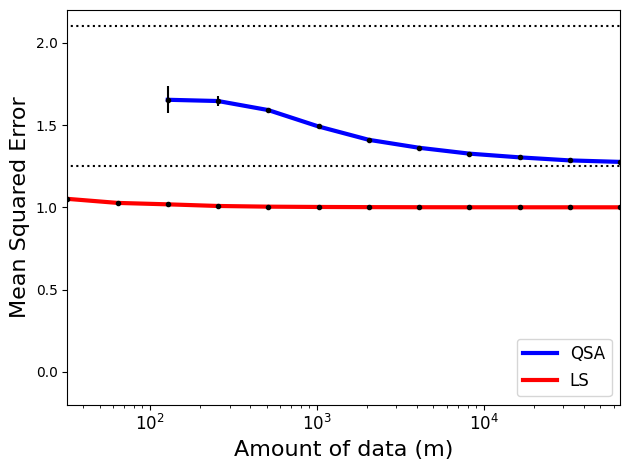

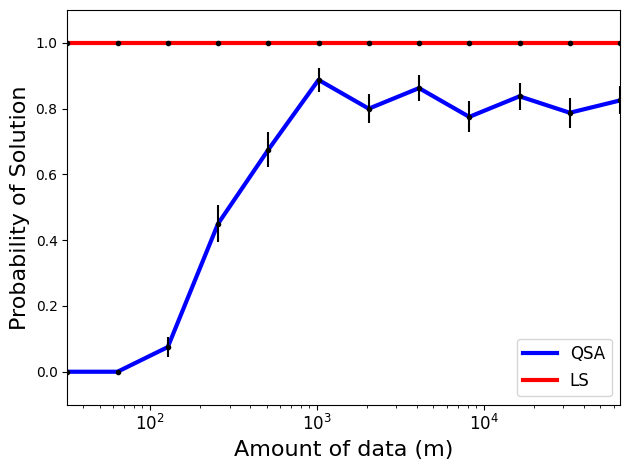

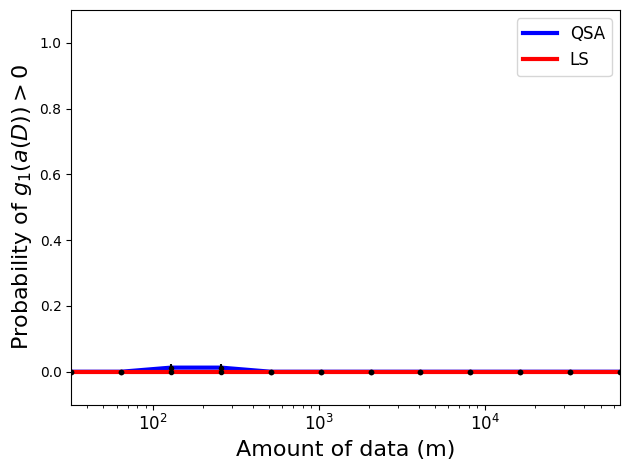

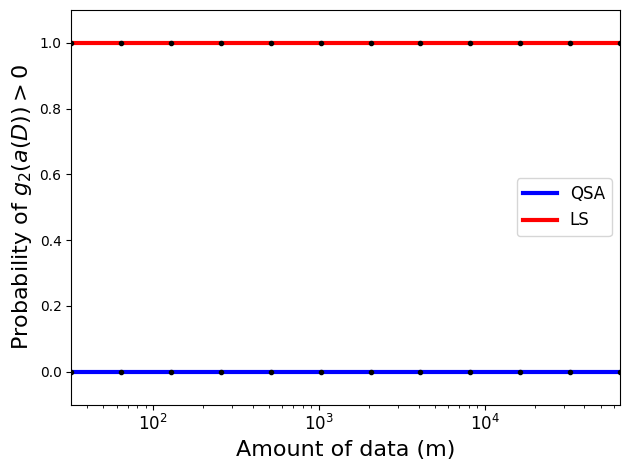

In [12]:
gather_results()

loadAndPlotResults(csv_path+'fs.csv',              'Mean Squared Error',            img_path+'tutorial7MSE_py.png',     False, 'lower right')
loadAndPlotResults(csv_path+'solutions_found.csv', 'Probability of Solution',       img_path+'tutorial7PrSoln_py.png',  True,  'best')
loadAndPlotResults(csv_path+'failures_g1.csv',     r'Probability of $g_1(a(D))>0$', img_path+'tutorial7PrFail1_py.png', True,  'best')
loadAndPlotResults(csv_path+'failures_g2.csv',     r'Probability of $g_2(a(D))>0$', img_path+'tutorial7PrFail2_py.png', True,  'best')
plt.show()